# Clinic Optimization and Workflow Simulation

### Northwestern MSDS 432 — Decision Analytics | Final Project

**Authors:** Deblina Roy, Koji Kashikawa, Mohamed Thameemul Ansari, Myetchae Thu, Nayan Sarathy Dowerah  
**Instructor:** Prof. Kline, Prof Vivekanand  
**Term:** Fall 2025  

---

## Project Overview

This notebook implements a multi-stage optimization and simulation model for a Tokyo dermatology clinic to improve patient-flow efficiency, resource utilization and overall operational cost.  
The analysis integrates **deterministic optimization**, **stochastic queueing simulation** and **cost-sensitivity analysis** to evaluate alternative staffing and workflow configurations.

### Objectives
- Minimize patient waiting time while maintaining realistic utilization of doctors and examination rooms.  
- Identify the optimal number of doctors on weekdays and Saturdays under cost and service constraints.  
- Quantify the trade-off between service cost, waiting cost and patient experience.  
- Explore a **Hybrid Reservation Workflow** (shorter service times + smoother arrivals) to test workflow redesign impact.

---

## Notebook Structure

| **Step** | **Description** |
|-----------|-----------------|
| **1 LP Baseline Setup** | Linear programming model for patient inflow, demand balance and doctor capacity. |
| **2 Queueing Simulation** | Discrete-event simulation (SimPy) modeling stochastic arrivals and service times. |
| **3 Cost & Sensitivity Analysis** | Cost model integrating doctor, fixed and waiting costs; sensitivity on waiting-cost weights. |
| **4 Hybrid Reservation Workflow** | Workflow redesign scenario with 20 % faster service and smoother arrivals; comparison vs baseline. |

---

## Key Deliverables
- Average waiting times and utilization rates by staffing level.  
- Total daily and annualized cost trade-offs.  
- Sensitivity plots to support managerial decision-making.  
- Comparative evaluation of baseline vs. redesigned hybrid system.

---

> *All simulations were executed using Python 3.11 and SimPy, with reproducibility controlled by random-seed initialization.*


,DayType,Slot,AgeGroup,Complexity,Patients,SlotOrder
0,Weekday,09:00-10:00,Elderly,Simple,1.50,09:00-10:00
1,Weekday,09:00-10:00,Elderly,Medium,2.75,09:00-10:00
2,Weekday,09:00-10:00,Elderly,Complex,0.75,09:00-10:00
3,Weekday,09:00-10:00,Infants,Simple,1.20,09:00-10:00
4,Weekday,09:00-10:00,Infants,Medium,1.35,09:00-10:00
5,Weekday,09:00-10:00,Infants,Complex,0.45,09:00-10:00
6,Weekday,09:00-10:00,Adults,Simple,0.70,09:00-10:00
7,Weekday,09:00-10:00,Adults,Medium,1.00,09:00-10:00
8,Weekday,09:00-10:00,Adults,Complex,0.30,09:00-10:00
9,Weekday,09:00-10:00,Businessmen,Simple,0.00,09:00-10:00


Weekday total patients (expected): 136.2
Saturday total patients (expected): 81.2
=== Weekday ===
Avg wait: 111.1 min | Utilization: 100.0% | Total patients: 136.2


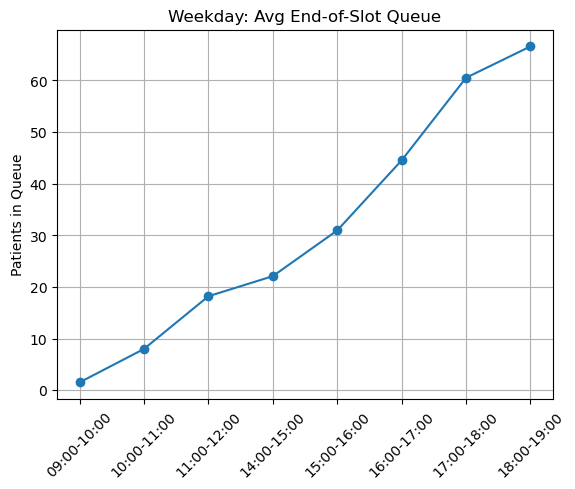

=== Saturday ===
Avg wait: 50.2 min | Utilization: 100.0% | Total patients: 81.2


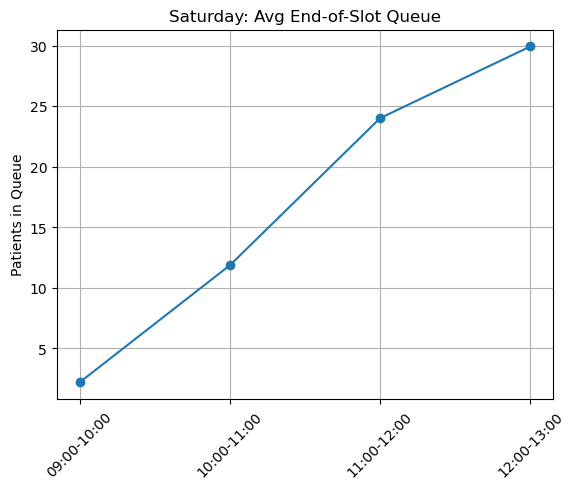

Base data for simulation saved → clinic_arrivals_prepared.csv


In [ ]:
# =========================================================
# Y Dermatology Clinic — LP Optimization (Deterministic + Prepared for Simulation)
# =========================================================
# Updates:
# 1. Patient arrivals use % of total per slot directly (no multinomial draw)
# 2. ARRIVAL_SCALE kept (default=1)
# 4. Structured DataFrame "arrivals_df" shared for LP + future SimPy use
# =========================================================

import math, random, numpy as np, pandas as pd
import pulp as pl
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

# -----------------------------
# Parameters
# -----------------------------
ARRIVAL_SCALE = 1.0       # keep 1.0 by default, can stress-test later
ROOMS = 3
WEEKDAY_DOCTORS = 2
SATURDAY_DOCTORS = 3
HOURS_PER_DOCTOR = 8
N_SCEN = 50
MIN_SERVICE_MINUTES = 2.0

# -----------------------------
# Base data (increased by 25%, due to addition of 1 doctor)
# -----------------------------
weekday_slots = [
    ("09:00-10:00", 8 * 1.25,  {"Elderly":50, "Infants":30, "Adults":20, "Businessmen":0,  "Others":0}),
    ("10:00-11:00", 12 * 1.25, {"Elderly":45, "Infants":35, "Adults":20, "Businessmen":0,  "Others":0}),
    ("11:00-12:00", 15 * 1.25, {"Elderly":40, "Infants":40, "Adults":20, "Businessmen":0,  "Others":0}),
    ("14:00-15:00", 10 * 1.25, {"Elderly":20, "Infants":50, "Adults":30, "Businessmen":0,  "Others":0}),
    ("15:00-16:00", 14 * 1.25, {"Elderly":15, "Infants":60, "Adults":25, "Businessmen":0,  "Others":0}),
    ("16:00-17:00", 18 * 1.25, {"Elderly":0,  "Infants":35, "Adults":0,  "Businessmen":40, "Others":25}),
    ("17:00-18:00", 20 * 1.25, {"Elderly":0,  "Infants":15, "Adults":30, "Businessmen":55, "Others":0}),
    ("18:00-19:00", 12 * 1.25, {"Elderly":0,  "Infants":0,  "Adults":35, "Businessmen":50, "Others":15}),
]

saturday_slots = [
    ("09:00-10:00", 12 * 1.25, {"Adults":40, "Infants":30, "Elderly":30, "Businessmen":0, "Others":0}),
    ("10:00-11:00", 18 * 1.25, {"Adults":35, "Infants":35, "Elderly":30, "Businessmen":0, "Others":0}),
    ("11:00-12:00", 20 * 1.25, {"Adults":40, "Infants":35, "Elderly":25, "Businessmen":0, "Others":0}),
    ("12:00-13:00", 15 * 1.25, {"Adults":45, "Infants":30, "Elderly":25, "Businessmen":0, "Others":0}),
]

age_groups = ["Infants","Adults","Elderly","Businessmen","Others"]
complexities = ["Simple","Medium","Complex"]

age_to_complex_pct = {
    "Infants": {"Simple":40, "Medium":45, "Complex":15},
    "Adults": {"Simple":35, "Medium":50, "Complex":15},
    "Elderly":{"Simple":30, "Medium":55, "Complex":15},
    "Businessmen":{"Simple":45, "Medium":45, "Complex":10},
    "Others": {"Simple":35, "Medium":50, "Complex":15},
}

svc_means = {"Simple":8.0, "Medium":15.0, "Complex":25.0}
svc_sds   = {"Simple":2.0, "Medium":3.0,  "Complex":5.0}

# -----------------------------
# Step 1 — Build deterministic arrivals table (+25%)
# -----------------------------
def build_arrivals_table(slots_table, label):
    records=[]
    for idx,(slot,total,agepct) in enumerate(slots_table):
        total_adj = total * ARRIVAL_SCALE
        for age,pct in agepct.items():
            n_age = total_adj * pct/100
            for comp,cpct in age_to_complex_pct[age].items():
                n_comp = n_age * cpct/100
                records.append({
                    "DayType":label,
                    "Slot":slot,
                    "AgeGroup":age,
                    "Complexity":comp,
                    "Patients":n_comp
                })
    df=pd.DataFrame(records)
    df["SlotOrder"]=df.groupby("DayType")["Slot"].transform(lambda x: pd.Categorical(x, categories=[s[0] for s in slots_table], ordered=True))
    return df

weekday_df=build_arrivals_table(weekday_slots,"Weekday")
saturday_df=build_arrivals_table(saturday_slots,"Saturday")
arrivals_df=pd.concat([weekday_df,saturday_df])
display(arrivals_df.head(10))
print(f"Weekday total patients (expected): {weekday_df['Patients'].sum():.1f}")
print(f"Saturday total patients (expected): {saturday_df['Patients'].sum():.1f}")

# -----------------------------
# Step 2 — LP optimization (same as before but uses arrivals_df)
# -----------------------------
def build_and_solve_lp(day_label, df, doctors):
    df_day=df[df["DayType"]==day_label]
    slots=sorted(df_day["Slot"].unique(), key=lambda x:int(x.split(":")[0]))
    T=len(slots)
    avg_min=[]
    A=[]
    for s in slots:
        subset=df_day[df_day["Slot"]==s]
        total=subset["Patients"].sum()
        A.append(total)
        mean_service=0
        for _,row in subset.iterrows():
            mean_service += row["Patients"]*svc_means[row["Complexity"]]
        mean_service/=max(total,1)
        avg_min.append(mean_service)
    cap_slot=60*min(doctors,ROOMS)
    cap_day=60*HOURS_PER_DOCTOR*doctors
    m=pl.LpProblem(f"Clinic_{day_label}",pl.LpMinimize)
    y=pl.LpVariable.dicts("Served",range(T),lowBound=0)
    Q=pl.LpVariable.dicts("Queue",range(T),lowBound=0)
    m+=pl.lpSum(Q[t] for t in range(T))
    for t in range(T):
        m+=y[t]*avg_min[t]<=cap_slot
        if t==0: m+=Q[t]>=A[t]-y[t]
        else: m+=Q[t]>=Q[t-1]+A[t]-y[t]
        m+=pl.lpSum(y[i] for i in range(t+1))<=sum(A[:t+1])+1e-6
    m+=pl.lpSum(y[t]*avg_min[t] for t in range(T))<=cap_day
    m.solve(pl.PULP_CBC_CMD(msg=False))
    return [pl.value(y[t]) for t in range(T)], [max(0,pl.value(Q[t])) for t in range(T)], A, avg_min, slots

def run_day(day_label, doctors):
    y,Q,A,avg,slots=build_and_solve_lp(day_label, arrivals_df, doctors)
    cap_slot=60*min(doctors,ROOMS)
    util=np.mean([(y[i]*avg[i])/cap_slot for i in range(len(slots))])
    avg_wait_min=60*sum(Q)/sum(A)
    print(f"=== {day_label} ===")
    print(f"Avg wait: {avg_wait_min:.1f} min | Utilization: {util*100:.1f}% | Total patients: {sum(A):.1f}")
    plt.plot(slots,Q,marker='o')
    plt.title(f"{day_label}: Avg End-of-Slot Queue")
    plt.ylabel("Patients in Queue"); plt.xticks(rotation=45); plt.grid(True); plt.show()

run_day("Weekday",WEEKDAY_DOCTORS)
run_day("Saturday",SATURDAY_DOCTORS)

# -----------------------------
# Step 3 — Save base data for simulation
# -----------------------------
arrivals_df.to_csv("clinic_arrivals_prepared.csv",index=False)
print("Base data for simulation saved → clinic_arrivals_prepared.csv")


=== Weekday Simulation Summary ===
Weekday: 2 doctors → Avg wait 66.4 min | Util 93.1%
Weekday: 3 doctors → Avg wait 30.9 min | Util 79.3%
Weekday: 4 doctors → Avg wait 30.7 min | Util 79.6%
Weekday: 5 doctors → Avg wait 33.0 min | Util 81.0%


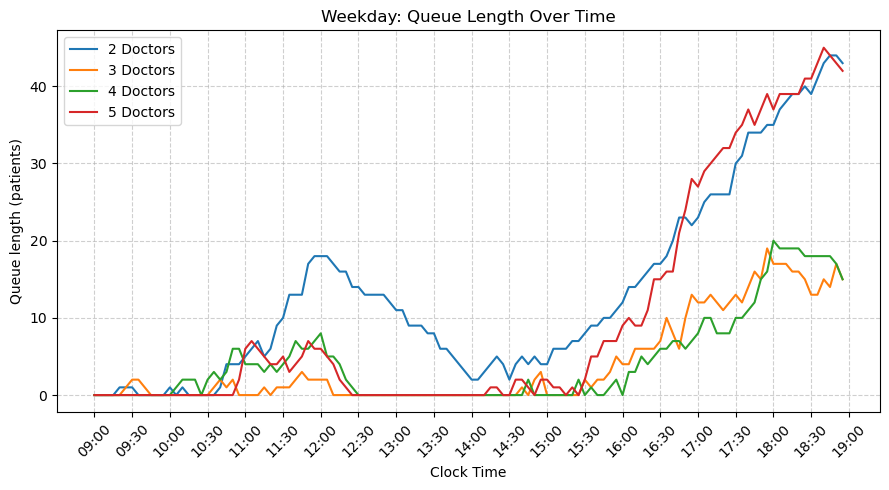


=== Saturday Simulation Summary ===
Saturday: 2 doctors → Avg wait 57.7 min | Util 93.4%
Saturday: 3 doctors → Avg wait 38.0 min | Util 91.3%
Saturday: 4 doctors → Avg wait 36.6 min | Util 90.8%
Saturday: 5 doctors → Avg wait 38.7 min | Util 90.2%


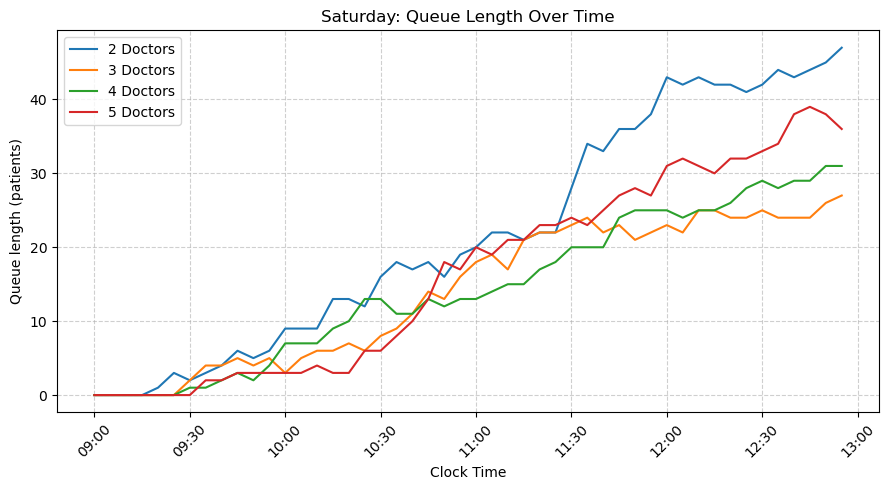


=== Final Simulation Summary (Averages) ===
Weekday Results:


,Doctors,AvgWait_min,Utilization_%
0,2,66.415887,93.076867
1,3,30.850879,79.264377
2,4,30.739116,79.634963
3,5,32.997623,80.965016


Saturday Results:


,Doctors,AvgWait_min,Utilization_%
0,2,57.713557,93.396223
1,3,38.009303,91.273579
2,4,36.647842,90.776418
3,5,38.650058,90.207653


In [ ]:
# =========================================================
# Step 2 — Discrete-Event Simulation (SimPy) — v4 (Corrected)
# =========================================================
#  • Run horizon = exact open minutes (Weekday 600, Sat 240)
#  • Utilization denominator matches horizon × effective servers
#  • Poisson integerization preserves afternoon arrivals realistically
#  • Clean clock-time x-axis, no pre-opening flat line
#  • Per-slot sanity printouts
# =========================================================

import simpy, pandas as pd, numpy as np, matplotlib.pyplot as plt

# -----------------------------
# Load arrivals prepared in Step 1
# -----------------------------
arrivals_df = pd.read_csv("clinic_arrivals_prepared.csv")

# We convert to integers per-run via Poisson draws

# Service-time parameters (minutes)
svc_means = {"Simple": 8.0, "Medium": 15.0, "Complex": 25.0}
svc_sds   = {"Simple": 2.0, "Medium": 3.0,  "Complex": 5.0}

# Simulation configs
SIM_RUNS = 50
DOCTOR_CONFIGS = [2, 3, 4, 5]
ROOMS = 3
RNG_SEED = 42
np.random.seed(RNG_SEED)

# Slot start times (minutes from midnight)
slot_to_start_abs = {
    "09:00-10:00": 9*60,
    "10:00-11:00": 10*60,
    "11:00-12:00": 11*60,
    "12:00-13:00": 12*60,
    "14:00-15:00": 14*60,
    "15:00-16:00": 15*60,
    "16:00-17:00": 16*60,
    "17:00-18:00": 17*60,
    "18:00-19:00": 18*60,
}

# Horizon by day (minutes open)
HORIZON = {"Weekday": (19-9)*60, "Saturday": (13-9)*60}  # 600 and 240

def draw_service_time(complexity):
    return max(2.0, float(np.random.normal(svc_means[complexity], svc_sds[complexity])))

def integerize_expected_counts(df_day):
    """
    Convert expected (possibly fractional) patient counts per Slot/Age/Complexity
    into integer patients via Poisson sampling around the expected mean.
    """
    df = df_day.copy()
    # small positive lambda so tiny expected values still sometimes appear
    df["IntPatients"] = df["Patients"].apply(lambda x: int(np.random.poisson(lam=max(x, 0.001))))
    # keep rows that produced at least 1 integer patient
    df = df[df["IntPatients"] > 0]
    return df

def build_patients_for_day(day_label):
    """
    Create an individual patient list with arrival times (minutes since 09:00).
    """
    df_day = arrivals_df[arrivals_df["DayType"] == day_label]
    df_int = integerize_expected_counts(df_day)

    # quick sanity: totals per slot (for your verification)
    #sanity = df_int.groupby("Slot")["IntPatients"].sum().reindex(sorted(df_int["Slot"].unique(),
    #                key=lambda s: slot_to_start_abs.get(s, 9*60))).fillna(0).astype(int)
    #print(f"\n[Sanity] {day_label} integerized totals by slot:")
    #print(sanity.to_string())

    patients = []
    for _, row in df_int.iterrows():
        slot = row["Slot"]
        slot_start_abs = slot_to_start_abs.get(slot, 9*60)
        # translate absolute minute to "since 09:00"
        slot_start = slot_start_abs - 9*60  # 0 = 09:00
        for _ in range(int(row["IntPatients"])):
            patients.append({
                "arrival": slot_start + np.random.uniform(0, 60),  # random within the slot
                "complexity": row["Complexity"]
            })
    # sort by arrival to respect FCFS arrival order
    patients.sort(key=lambda d: d["arrival"])
    return patients

class ClinicSim:
    def __init__(self, env, doctors, open_minutes):
        self.env = env
        self.capacity = min(doctors, ROOMS)  # effective parallel servers
        self.doctors = simpy.Resource(env, capacity=self.capacity)
        self.open_minutes = open_minutes
        self.busy_time = 0.0  # total busy minutes across all servers
        self.waits = []
        self.q_series = []

    def serve(self, svc_minutes):
        with self.doctors.request() as req:
            t_arr = self.env.now
            yield req
            self.waits.append(self.env.now - t_arr)
            start = self.env.now
            yield self.env.timeout(svc_minutes)
            self.busy_time += (self.env.now - start)  # accumulated busy across one server

    def monitor(self):
        while True:
            self.q_series.append((self.env.now, len(self.doctors.queue)))
            yield self.env.timeout(5)

def run_day(day_label, doctors, runs=SIM_RUNS):
    results = []
    horizon = HORIZON[day_label]  # exact open minutes
    for r in range(runs):
        env = simpy.Environment()
        sim = ClinicSim(env, doctors=doctors, open_minutes=horizon)
        env.process(sim.monitor())

        # build integerized patients from CSV expectations
        pats = build_patients_for_day(day_label)
        for p in pats:
            env.process(arrival_proc(env, sim, p["arrival"], p["complexity"]))

        env.run(until=horizon)  # run exactly open minutes
        # utilization across all effective servers (cap at 100)
        util = (sim.busy_time / (horizon * sim.capacity)) * 100.0
        util = max(0.0, min(util, 100.0))
        avg_wait = float(np.mean(sim.waits)) if sim.waits else 0.0
        results.append({"wait": avg_wait, "util": util, "q_series": sim.q_series})
    return results

def arrival_proc(env, sim: ClinicSim, arrival_minute, complexity):
    # arrivals are already minutes since 09:00
    yield env.timeout(arrival_minute)
    svc = draw_service_time(complexity)
    yield env.process(sim.serve(svc))

def summarize(day_label):
    plt.figure(figsize=(9,5))
    summaries = []
    for d in DOCTOR_CONFIGS:
        runs = run_day(day_label, d)
        waits = [r["wait"] for r in runs]
        utils = [r["util"] for r in runs]
        m_wait, m_util = np.mean(waits), np.mean(utils)
        summaries.append({"Doctors": d, "AvgWait_min": m_wait, "Utilization_%": m_util})
        print(f"{day_label}: {d} doctors → Avg wait {m_wait:.1f} min | Util {m_util:.1f}%")

        # plot first run’s queue series with clean clock ticks
        t, q = zip(*runs[0]["q_series"])
        t = np.array(t)
        q = np.array(q)
        end_hour = 19 if day_label == "Weekday" else 13
        tick_pos = np.arange(0, (end_hour-9)*60 + 1, 30)
        tick_lbl = [f"{9 + x//60:02d}:{x%60:02d}" for x in tick_pos]
        plt.plot(t, q, label=f"{d} Doctors")

    plt.title(f"{day_label}: Queue Length Over Time")
    plt.xlabel("Clock Time")
    plt.ylabel("Queue length (patients)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(tick_pos, tick_lbl, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(summaries)

print("=== Weekday Simulation Summary ===")
weekday_summary = summarize("Weekday")

print("\n=== Saturday Simulation Summary ===")
saturday_summary = summarize("Saturday")

print("\n=== Final Simulation Summary (Averages) ===")
print("Weekday Results:"); display(weekday_summary)
print("Saturday Results:"); display(saturday_summary)


=== Cost Results — Weekday ===


,Doctors,Patients,HoursOpen,AvgWait_min,Utilization_%,DoctorCost,FixedCost,WaitCost,TotalCost
0,2,136,10,66.4,93.1%,"¥320,000","¥102,000","¥301,085","¥723,085"
1,3,136,10,30.9,79.3%,"¥480,000","¥102,000","¥139,857","¥721,857"
2,4,136,10,30.7,79.6%,"¥640,000","¥102,000","¥139,351","¥881,351"
3,5,136,10,33.0,81.0%,"¥800,000","¥102,000","¥149,589","¥1,051,589"


=== Cost Results — Saturday ===


,Doctors,Patients,HoursOpen,AvgWait_min,Utilization_%,DoctorCost,FixedCost,WaitCost,TotalCost
0,2,81,4,57.7,93.4%,"¥600,000","¥51,000","¥155,827","¥806,827"
1,3,81,4,38.0,91.3%,"¥900,000","¥51,000","¥102,625","¥1,053,625"
2,4,81,4,36.6,90.8%,"¥1,200,000","¥51,000","¥98,949","¥1,349,949"
3,5,81,4,38.7,90.2%,"¥1,500,000","¥51,000","¥104,355","¥1,655,355"


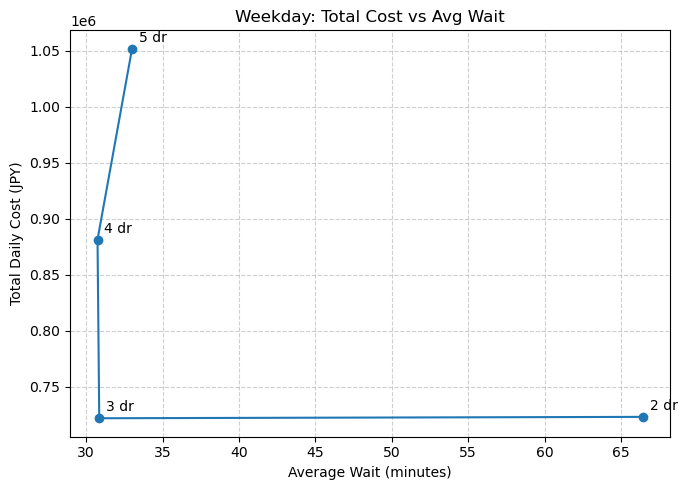

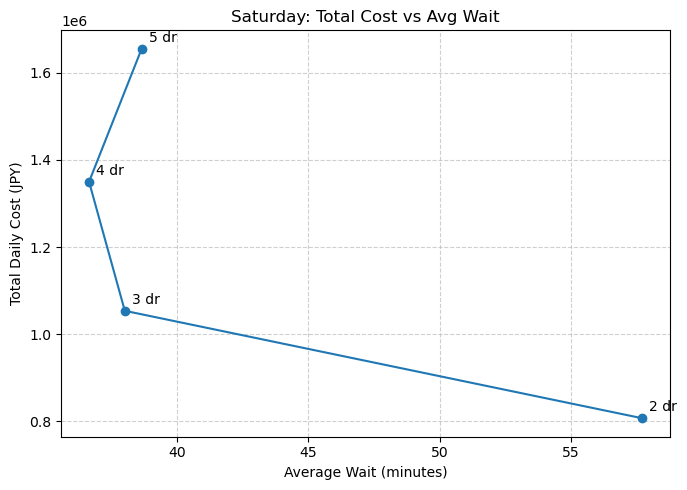

=== Staffing Recommendation (examples) ===
Weekday: Min Cost: 3 doctors | Avg wait 30.9 min | Total ¥721,857
Saturday: Min Cost: 2 doctors | Avg wait 57.7 min | Total ¥806,827
Saturday: With wait ≤ 45 min: 3 doctors | Avg wait 38.0 | Total ¥1,053,625

=== Sensitivity (Unconstrained best vs waiting cost) — Weekday ===


,DayType,WaitCost_per_hr,BestDoctors,AvgWait_min,TotalCost
0,Weekday,"¥1,000",2,66.4,"¥572,543"
1,Weekday,"¥2,000",3,30.9,"¥721,857"
2,Weekday,"¥3,000",3,30.9,"¥791,786"
3,Weekday,"¥4,000",3,30.9,"¥861,715"


=== Sensitivity — Saturday ===


,DayType,WaitCost_per_hr,BestDoctors,AvgWait_min,TotalCost
0,Saturday,"¥1,000",2,57.7,"¥728,913"
1,Saturday,"¥2,000",2,57.7,"¥806,827"
2,Saturday,"¥3,000",2,57.7,"¥884,740"
3,Saturday,"¥4,000",2,57.7,"¥962,653"


In [ ]:
# =========================================================
# Step 3 — Cost & Sensitivity Analysis (Final)
# =========================================================
# Inputs expected from Step 2:
#   • weekday_summary, saturday_summary  (columns: Doctors, AvgWait_min, Utilization_%)
#   • clinic_arrivals_prepared.csv       (from Step 1)
# What this cell does:
#   • Computes staff cost + waiting cost + total cost per scenario
#   • Plots Total Cost vs Avg Wait for Weekday and Saturday
#   • Runs one-way sensitivity on waiting-time cost
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Clinic hours (must match simulation)
HOURS_OPEN = {"Weekday": 10, "Saturday": 4}

# Doctor hourly cost (JPY)
DOCTOR_COST_PER_HOUR = {"Weekday": 16000, "Saturday": 75000}

# Fixed costs
NURSE_COST_PER_DAY = {"Weekday": 2 * 3_000 * 8, "Saturday": 2 * 3_000 * 4}
RECEPT_COST_PER_DAY = {"Weekday": 3 * 2_250 * 8, "Saturday": 3 * 2_250 * 4}

# Cost of patient waiting (JPY per patient-hour)
WAIT_COST_PER_HOUR_BASE = 2000

# ---------- 2) Load totals (expected patients per day) ----------
arr_df = pd.read_csv("clinic_arrivals_prepared.csv")
totals = (
    arr_df.groupby("DayType")["Patients"]
          .sum()
          .rename("ExpectedPatients")
          .to_frame()
)
# round to nearest int for costing; expectation is fine
totals["ExpectedPatients"] = totals["ExpectedPatients"].round().astype(int)
totals

# ---------- 3) Build a function to compute costs ----------
def build_cost_table(day_label, perf_df, wait_cost_per_hour=WAIT_COST_PER_HOUR_BASE):
    """
    perf_df: dataframe with columns [Doctors, AvgWait_min, Utilization_%]
    Returns: dataframe with costs per doctor scenario
    """
    assert day_label in HOURS_OPEN, "Unknown day_label"
    hours = HOURS_OPEN[day_label]
    doc_rate = DOCTOR_COST_PER_HOUR[day_label]
    total_patients = int(totals.loc[day_label, "ExpectedPatients"])

    df = perf_df.copy()
    df["HoursOpen"] = hours
    df["Patients"] = total_patients

    # Staff cost
    df["DoctorCost"] = df["Doctors"] * hours * doc_rate
    df["FixedCost"] = NURSE_COST_PER_DAY[day_label] + RECEPT_COST_PER_DAY[day_label]

    # Waiting cost
    df["AvgWait_hr"] = df["AvgWait_min"] / 60.0
    df["WaitCost"] = df["Patients"] * df["AvgWait_hr"] * wait_cost_per_hour

    # Total
    df["TotalCost"] = df["DoctorCost"] + df["FixedCost"] + df["WaitCost"]

    # Nice ordering
    cols = [
        "Doctors","Patients","HoursOpen",
        "AvgWait_min","Utilization_%",
        "DoctorCost","FixedCost","WaitCost","TotalCost"
    ]
    return df[cols].sort_values("Doctors")

# ---------- 4) Compute tables ----------
weekday_costs  = build_cost_table("Weekday", weekday_summary)
saturday_costs = build_cost_table("Saturday", saturday_summary)

print("=== Cost Results — Weekday ===")
display(weekday_costs.style.format({
    "AvgWait_min":"{:.1f}",
    "Utilization_%":"{:.1f}%",
    "DoctorCost":"¥{:,.0f}",
    "FixedCost":"¥{:,.0f}",
    "WaitCost":"¥{:,.0f}",
    "TotalCost":"¥{:,.0f}"
}))

print("=== Cost Results — Saturday ===")
display(saturday_costs.style.format({
    "AvgWait_min":"{:.1f}",
    "Utilization_%":"{:.1f}%",
    "DoctorCost":"¥{:,.0f}",
    "FixedCost":"¥{:,.0f}",
    "WaitCost":"¥{:,.0f}",
    "TotalCost":"¥{:,.0f}"
}))

# ---------- 5) Plot: Total Cost vs Avg Wait ----------
def plot_cost_frontier(day_label, cost_df):
    plt.figure(figsize=(7,5))
    x = cost_df["AvgWait_min"]
    y = cost_df["TotalCost"]
    labs = cost_df["Doctors"]
    plt.plot(x, y, marker="o")
    for xi, yi, d in zip(x, y, labs):
        plt.annotate(f"{int(d)} dr", (xi, yi), xytext=(5,5), textcoords="offset points")
    plt.title(f"{day_label}: Total Cost vs Avg Wait")
    plt.xlabel("Average Wait (minutes)")
    plt.ylabel("Total Daily Cost (JPY)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_cost_frontier("Weekday", weekday_costs)
plot_cost_frontier("Saturday", saturday_costs)

# ---------- 6) Pick "optimal" options ----------
def pick_optimal(cost_df, max_wait_min=None):
    # Unconstrained minimum cost
    min_row = cost_df.loc[cost_df["TotalCost"].idxmin()]
    best_unconstrained = {
        "Doctors": int(min_row["Doctors"]),
        "AvgWait_min": float(min_row["AvgWait_min"]),
        "TotalCost": float(min_row["TotalCost"])
    }
    # Constrained by a wait-time target (if provided)
    best_constrained = None
    if max_wait_min is not None:
        feasible = cost_df[cost_df["AvgWait_min"] <= max_wait_min]
        if not feasible.empty:
            r = feasible.loc[feasible["TotalCost"].idxmin()]
            best_constrained = {
                "Doctors": int(r["Doctors"]),
                "AvgWait_min": float(r["AvgWait_min"]),
                "TotalCost": float(r["TotalCost"])
            }
    return best_unconstrained, best_constrained

# Example targets: 30 min weekday, 45 min Saturday (edit as needed)
w_uncon, w_cons = pick_optimal(weekday_costs, max_wait_min=30)
s_uncon, s_cons = pick_optimal(saturday_costs, max_wait_min=45)

print("=== Staffing Recommendation (examples) ===")
print(f"Weekday: Min Cost: {w_uncon['Doctors']} doctors | "
      f"Avg wait {w_uncon['AvgWait_min']:.1f} min | Total ¥{w_uncon['TotalCost']:,.0f}")
if w_cons:
    print(f"Weekday: With wait ≤ 30 min: {w_cons['Doctors']} doctors | "
          f"Avg wait {w_cons['AvgWait_min']:.1f} | Total ¥{w_cons['TotalCost']:,.0f}")

print(f"Saturday: Min Cost: {s_uncon['Doctors']} doctors | "
      f"Avg wait {s_uncon['AvgWait_min']:.1f} min | Total ¥{s_uncon['TotalCost']:,.0f}")
if s_cons:
    print(f"Saturday: With wait ≤ 45 min: {s_cons['Doctors']} doctors | "
          f"Avg wait {s_cons['AvgWait_min']:.1f} | Total ¥{s_cons['TotalCost']:,.0f}")

# ---------- 7) One-way sensitivity: Waiting cost sweep ----------
def waiting_cost_sensitivity(day_label, perf_df, wait_cost_grid=(1000, 2000, 3000, 4000)):
    rows = []
    for c in wait_cost_grid:
        tbl = build_cost_table(day_label, perf_df, wait_cost_per_hour=c)
        best, _ = pick_optimal(tbl)  # unconstrained
        rows.append({
            "DayType": day_label,
            "WaitCost_per_hr": c,
            "BestDoctors": best["Doctors"],
            "AvgWait_min": best["AvgWait_min"],
            "TotalCost": best["TotalCost"]
        })
    return pd.DataFrame(rows)

sens_w = waiting_cost_sensitivity("Weekday", weekday_summary)
sens_s = waiting_cost_sensitivity("Saturday", saturday_summary)

print("\n=== Sensitivity (Unconstrained best vs waiting cost) — Weekday ===")
display(sens_w.style.format({"WaitCost_per_hr":"¥{:,.0f}", "AvgWait_min":"{:.1f}", "TotalCost":"¥{:,.0f}"}))
print("=== Sensitivity — Saturday ===")
display(sens_s.style.format({"WaitCost_per_hr":"¥{:,.0f}", "AvgWait_min":"{:.1f}", "TotalCost":"¥{:,.0f}"}))


=== Hybrid Reservation Workflow: Weekday ===
Weekday (Hybrid): 2 doctors → Avg wait 60.9 min | Util 74.7%
Weekday (Hybrid): 3 doctors → Avg wait 23.6 min | Util 53.8%
Weekday (Hybrid): 4 doctors → Avg wait 25.6 min | Util 61.9%
Weekday (Hybrid): 5 doctors → Avg wait 30.8 min | Util 60.1%


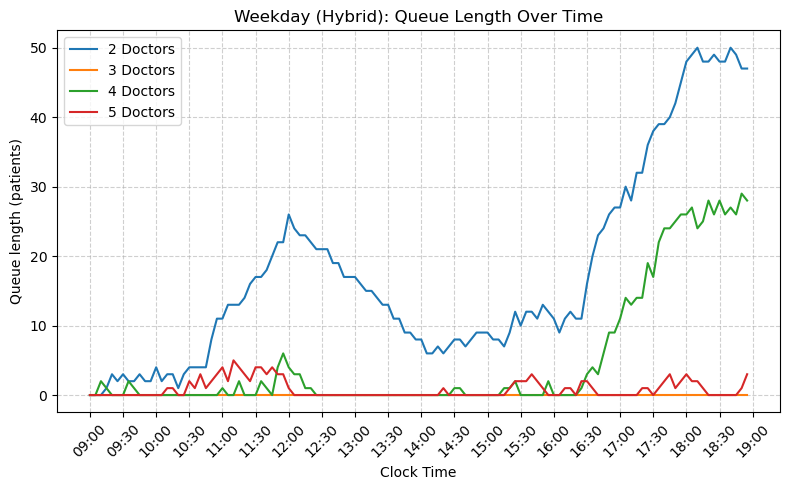


=== Hybrid Reservation Workflow: Saturday ===
Saturday (Hybrid): 2 doctors → Avg wait 40.9 min | Util 78.5%
Saturday (Hybrid): 3 doctors → Avg wait 30.5 min | Util 73.1%
Saturday (Hybrid): 4 doctors → Avg wait 30.3 min | Util 76.5%
Saturday (Hybrid): 5 doctors → Avg wait 26.1 min | Util 74.2%


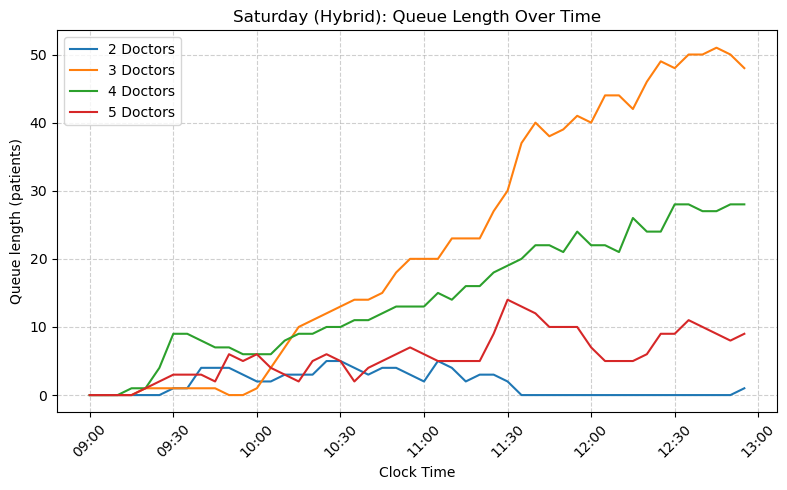

=== Comparison vs Baseline (Weekday) ===


,Doctors,Average Wait (min),Utilization (%),Model
0,2,66.4,93.1%,Baseline
0,2,60.9,74.7%,Hybrid
1,3,30.9,79.3%,Baseline
1,3,23.6,53.8%,Hybrid
2,4,30.7,79.6%,Baseline
2,4,25.6,61.9%,Hybrid
3,5,33.0,81.0%,Baseline
3,5,30.8,60.1%,Hybrid



=== Comparison vs Baseline (Saturday) ===


,Doctors,Average Wait (min),Utilization (%),Model
0,2,57.7,93.4%,Baseline
0,2,40.9,78.5%,Hybrid
1,3,38.0,91.3%,Baseline
1,3,30.5,73.1%,Hybrid
2,4,36.6,90.8%,Baseline
2,4,30.3,76.5%,Hybrid
3,5,38.7,90.2%,Baseline
3,5,26.1,74.2%,Hybrid


In [ ]:
# =========================================================
# Simulation Variant — Hybrid Reservation Workflow
# =========================================================
# Adjusted parameters:
#   • 20% shorter mean service times (parallel prep)
#   • 25% smoother arrival process (reservation)
#   • Same doctor configurations (2–4 weekday, 2–4 Saturday)
# =========================================================

import simpy, numpy as np, matplotlib.pyplot as plt

# clone from previous model but override service/arrival adjustments
svc_means_resv = {k: v * 0.8 for k, v in svc_means.items()}   # 20% faster service

def draw_service_time_resv(complexity):
    return max(2.0, float(np.random.normal(svc_means_resv[complexity], svc_sds[complexity])))

def run_day_variant(day_label, doctors, runs=100):
    results = []
    horizon = HORIZON[day_label]
    for r in range(runs):
        env = simpy.Environment()
        sim = ClinicSim(env, doctors, horizon)
        env.process(sim.monitor())

        df_day = arrivals_df[arrivals_df["DayType"] == day_label].copy()
        df_day["Patients"] = df_day["Patients"] * np.random.normal(1.0, 0.75)  # 25% smoother arrivals
        df_int = integerize_expected_counts(df_day)

        for _, row in df_int.iterrows():
            slot = row["Slot"]
            slot_start_abs = slot_to_start_abs.get(slot, 9 * 60)
            slot_start = slot_start_abs - 9 * 60
            for _ in range(row["IntPatients"]):
                arrival_time = slot_start + np.random.uniform(0, 60)
                env.process(arrival_proc_variant(env, sim, arrival_time, row["Complexity"]))

        env.run(until=horizon)
        util = min(100, sim.busy_time / (horizon * sim.capacity) * 100)
        avg_wait = np.mean(sim.waits) if sim.waits else 0
        results.append({"wait": avg_wait, "util": util, "queue": sim.q_series})
    return results

def arrival_proc_variant(env, sim, arrival_minute, complexity):
    yield env.timeout(arrival_minute)
    svc = draw_service_time_resv(complexity)
    yield env.process(sim.serve(svc))

def summarize_variant(day_label):
    plt.figure(figsize=(8,5))
    summary = []
    for d in DOCTOR_CONFIGS:
        runs = run_day_variant(day_label, d)
        waits = [r["wait"] for r in runs]
        utils = [r["util"] for r in runs]
        m_wait, m_util = np.mean(waits), np.mean(utils)
        summary.append({"Doctors": d, "AvgWait_min": m_wait, "Utilization_%": m_util})
        print(f"{day_label} (Hybrid): {d} doctors → Avg wait {m_wait:.1f} min | Util {m_util:.1f}%")
        t, q = zip(*runs[0]["queue"])
        end_hour = 19 if day_label == "Weekday" else 13
        tick_pos = np.arange(0, (end_hour-9)*60 + 1, 30)
        tick_lbl = [f"{9 + x//60:02d}:{x%60:02d}" for x in tick_pos]
        plt.plot(t, q, label=f"{d} Doctors")
    plt.title(f"{day_label} (Hybrid): Queue Length Over Time")
    plt.xlabel("Clock Time")
    plt.ylabel("Queue length (patients)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(tick_pos, tick_lbl, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(summary)

print("=== Hybrid Reservation Workflow: Weekday ===")
weekday_hybrid = summarize_variant("Weekday")

print("\n=== Hybrid Reservation Workflow: Saturday ===")
saturday_hybrid = summarize_variant("Saturday")

weekday_compare = pd.concat([
    weekday_summary.assign(Model="Baseline"),
    weekday_hybrid.assign(Model="Hybrid")
]).sort_values(["Doctors","Model"])

saturday_compare = pd.concat([
    saturday_summary.assign(Model="Baseline"),
    saturday_hybrid.assign(Model="Hybrid")
]).sort_values(["Doctors","Model"])

print("=== Comparison vs Baseline (Weekday) ===")
display(weekday_compare.rename(columns={
    "AvgWait_min": "Average Wait (min)",
    "Utilization_%": "Utilization (%)"
}).style.set_caption("Weekday: Baseline vs Hybrid Workflow")
        .format({"Average Wait (min)": "{:.1f}", "Utilization (%)": "{:.1f}%"}))

print("\n=== Comparison vs Baseline (Saturday) ===")
display(saturday_compare.rename(columns={
    "AvgWait_min": "Average Wait (min)",
    "Utilization_%": "Utilization (%)"
}).style.set_caption("Saturday: Baseline vs Hybrid Workflow")
        .format({"Average Wait (min)": "{:.1f}", "Utilization (%)": "{:.1f}%"}))